Treshold: 35


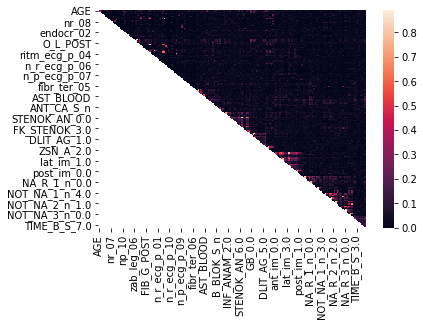

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("MI_DB.csv", index_col=0)
# Replace to NaN and convert to float
df = df.replace("?", np.nan)
df = df.apply(pd.to_numeric)

record_count = df.count().to_numpy()
indexes_high_na = np.where( record_count < 1700/2)[0]

name_dropped = df.columns[indexes_high_na].to_numpy() #Keep track of the names of the columns we drop
df = df.drop(df.columns[indexes_high_na], axis = 1)

treshold_na = int(0.3*119) # if more that 50% of missing values, get rid of the row (59)
print("Treshold:",treshold_na)

def calculate_NA(row):
    return row.isna().sum().sum()

df["n_NA"] = df.apply(calculate_NA, axis=1)

np.max(df["n_NA"])

df = df.drop(df[df["n_NA"] > treshold_na].index)
df = df.drop(["n_NA"], axis=1)

df["DEAD"] = df["LET_IS"].apply(lambda x: 1 if x > 0 else 0)

numeric_attributes = ["AGE","S_AD_KBRIG","D_AD_KBRIG","S_AD_ORIT","D_AD_ORIT","K_BLOOD","NA_BLOOD",
                      "ALT_BLOOD","AST_BLOOD","KFK_BLOOD","L_BLOOD","ROE"]

numeric_attributes = [x for x in numeric_attributes if x not in name_dropped]

ord_attributes = ["INF_ANAM","STENOK_AN","FK_STENOK","IBS_POST","GB","DLIT_AG","ZSN_A",
                  "ant_im","lat_im","inf_im","post_im","R_AB_1_n","NA_R_1_n","NOT_NA_1_n",
                 "R_AB_2_n","NA_R_2_n","NOT_NA_2_n","R_AB_3_n","NA_R_3_n","NOT_NA_3_n","TIME_B_S"]


ord_attributes = [x for x in ord_attributes if x not in name_dropped]

Y_labels = ["FIBR_PREDS","PREDS_TAH","JELUD_TAH","FIBR_JELUD","A_V_BLOK","OTEK_LANC","RAZRIV","DRESSLER","ZSN","REC_IM","P_IM_STEN","LET_IS","DEAD"]

att_names = list(df.columns)

bin_attributes = [x for x in att_names if x not in numeric_attributes+ord_attributes+Y_labels]
bin_attributes = [x for x in bin_attributes if x not in name_dropped]

colums_id_Y = [df.columns.get_loc(c) for c in Y_labels if c in df]

from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

scaler = preprocessing.StandardScaler()

pipe = make_pipeline(scaler, KNNImputer(n_neighbors=10))

imputer = KNNImputer(n_neighbors=3)
df_i = pipe.fit_transform(df)
df_i = scaler.inverse_transform(df_i)

sf_df = pd.DataFrame(df_i, index=df.index, columns=df.columns)

sf_df[ord_attributes]= sf_df[ord_attributes].apply(round,axis=1)

sf_df[bin_attributes]= sf_df[bin_attributes].apply(round,axis=1)

sf_df_dum = pd.get_dummies(sf_df, columns=ord_attributes)

x_cols = bin_attributes+ord_attributes+numeric_attributes
y_cols = Y_labels


x_cols = [x for x in sf_df_dum.columns if x not in Y_labels]

X = sf_df_dum[x_cols]
Y = sf_df_dum[y_cols]

cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

X = X.drop(to_drop, axis=1)
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
sns.heatmap(upper_tri)

scaler.fit(X)
X_sc = scaler.transform(X)
Y_dead = Y["DEAD"].to_numpy()
Y_dead = Y_dead.round().astype(int)

In [3]:
from sklearn.decomposition import PCA
from sklearn.decomposition import MiniBatchSparsePCA
pca = PCA(n_components=60,random_state=0)
#pca = PCA(n_components=50)
pca.fit(X_sc)
X_pca = pca.transform(X_sc)

# Grid search with C, not balancing

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score, confusion_matrix, accuracy_score,plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold




reg_param =np.logspace(-7,-3,100)
inner_cv = KFold(n_splits=5, shuffle=True)


auc_r = []
sen_t = []
spe_t = []
b_a =[]

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_pca)):
    x_train_l, x_test_l = X_pca[train_ids],X_pca[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    for reg_p in reg_param:

        mdl = LogisticRegression(solver="liblinear", max_iter=10000, C=reg_p)
        mdl.fit(x_train_l, y_train_l)
        probs = mdl.predict_proba(x_test_l)
        probs = probs[:, 1]
        auc = roc_auc_score(y_test_l, probs)
        y_pred = mdl.predict(x_test_l)
        tn, fp, fn, tp = confusion_matrix(y_test_l,y_pred).ravel()
        

        auc_r.append(auc)
        sen_t.append(tp/(tp+fn))
        spe_t.append(tn/(tn+fp))
        b_a.append(balanced_accuracy_score(y_test_l,y_pred))
    break;


Text(0.5, 0, 'C')

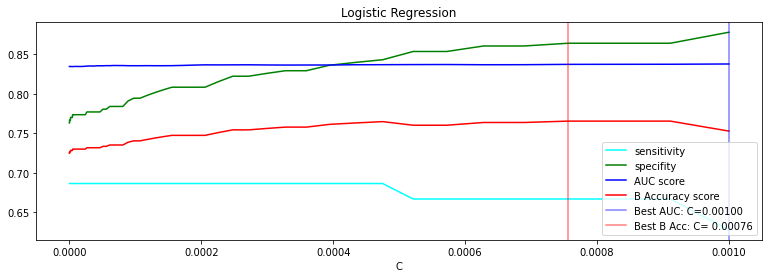

In [38]:
plt.rcParams["figure.figsize"] = (13,4)

plt.plot(reg_param,sen_t,label="sensitivity", color="cyan")
plt.plot(reg_param,spe_t,label="specifity", color="g")
plt.plot(reg_param,auc_r,label="AUC score",color="b")
plt.plot(reg_param,b_a,label="B Accuracy score",color="r")
plt.axvline(reg_param[np.argmax(auc_r)], 0, 1, label='Best AUC: C={:.5f}'.format(reg_param[np.argmax(auc_r)]), color="b", alpha=0.5)
plt.axvline(reg_param[np.argmax(b_a)], 0, 1, label='Best B Acc: C= {:.5f}'.format(reg_param[np.argmax(b_a)]), color="r", alpha=0.5)
plt.legend()
plt.title("Logistic Regression")
plt.xlabel("C")

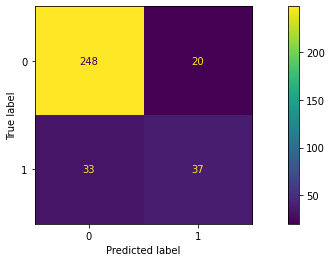

In [39]:
args = np.argwhere(b_a==np.max(b_a))

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl = LogisticRegression(solver="liblinear", max_iter=10000, C=reg_param[np.argmax(b_a)])
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)  

    break;

# Grid search C with balanced class weight

In [49]:
reg_param =np.logspace(-7,-2,100)
inner_cv = KFold(n_splits=5, shuffle=True)

auc_r = []
sen_t = []
spe_t = []
b_a =[]



for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_pca)):
    
    runauc_r = []
    runsen_t = []
    runspe_t = []
    runb_a =[]

    x_train_l, x_test_l = X_pca[train_ids],X_pca[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    for reg_p in reg_param:

        mdl = LogisticRegression(solver="liblinear", max_iter=10000, C=reg_p, class_weight="balanced")
        mdl.fit(x_train_l, y_train_l)
        probs = mdl.predict_proba(x_test_l)
        probs = probs[:, 1]
        auc = roc_auc_score(y_test_l, probs)
        y_pred = mdl.predict(x_test_l)
        tn, fp, fn, tp = confusion_matrix(y_test_l,y_pred).ravel()
        

        runauc_r.append(auc)
        runsen_t.append(tp/(tp+fn))
        runspe_t.append(tn/(tn+fp))
        runb_a.append(balanced_accuracy_score(y_test_l,y_pred))
        
    auc_r.append(runauc_r)
    sen_t.append(runsen_t)
    spe_t.append(runspe_t)
    b_a.append(runb_a)

auc_r = np.mean(auc_r, axis=0)
sen_t = np.mean(sen_t, axis=0)
spe_t = np.mean(spe_t, axis=0)
b_a = np.mean(b_a, axis=0)


Text(0.5, 0, 'C')

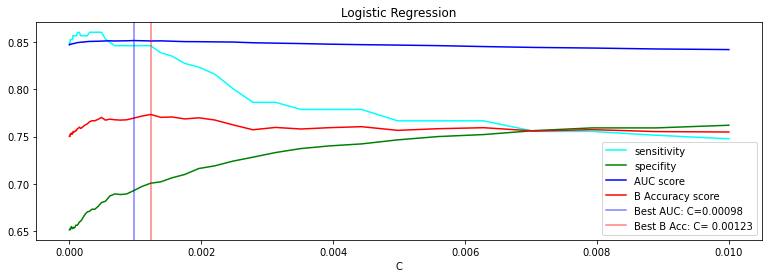

In [56]:
plt.rcParams["figure.figsize"] = (13,4)

plt.plot(reg_param,sen_t,label="sensitivity", color="cyan")
plt.plot(reg_param,spe_t,label="specifity", color="g")
plt.plot(reg_param,auc_r,label="AUC score",color="b")
plt.plot(reg_param,b_a,label="B Accuracy score",color="r")
plt.axvline(reg_param[np.argmax(auc_r)], 0, 1, label='Best AUC: C={:.5f}'.format(reg_param[np.argmax(auc_r)]), color="b", alpha=0.5)
plt.axvline(reg_param[np.argmax(b_a)], 0, 1, label='Best B Acc: C= {:.5f}'.format(reg_param[np.argmax(b_a)]), color="r", alpha=0.5)
plt.legend()
plt.title("Logistic Regression")
plt.xlabel("C")

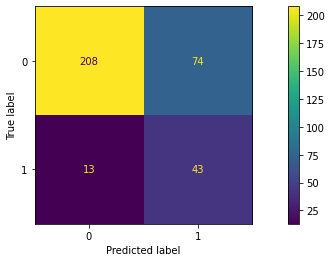

In [60]:
args = np.argwhere(b_a==np.max(b_a))

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl = LogisticRegression(solver="liblinear", max_iter=10000, C=reg_param[np.argmax(b_a)], class_weight="balanced")
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)  

    break;

# 2D Grid search with class weights

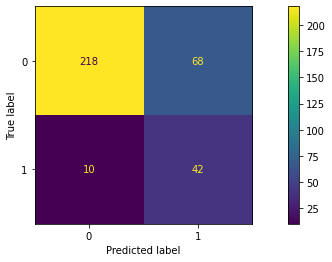

In [62]:
args = np.argwhere(b_a==np.max(b_a))


c_w = [{0:0.1,1:0.9},{0:0.3,1:0.7},{0:0.5,1:0.5},{0:0.7,1:0.3},{0:0.9,1:0.1}]


for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl = LogisticRegression(solver="liblinear", max_iter=10000, C=reg_param[np.argmax(b_a)], class_weight={0:0.1,1:0.2})
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)  

    break;

In [64]:
reg_param =np.logspace(-7,-2,100)
inner_cv = KFold(n_splits=5, shuffle=True)
c_w = [{0:0.1,1:0.9},{0:0.3,1:0.7},{0:0.5,1:0.5},{0:0.7,1:0.3},{0:0.9,1:0.1}]

auc_r = []
sen_t = []
spe_t = []
b_a =[]



for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_pca)):
    
    runauc_r = []
    runsen_t = []
    runspe_t = []
    runb_a =[]

    x_train_l, x_test_l = X_pca[train_ids],X_pca[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    for reg_p in reg_param:
        C_auc = []
        C_sen = []
        C_spe = []
        C_b_a = []
        for wei in c_w:
            mdl = LogisticRegression(solver="liblinear", max_iter=10000, C=reg_p, class_weight=wei)
            mdl.fit(x_train_l, y_train_l)
            probs = mdl.predict_proba(x_test_l)
            probs = probs[:, 1]
            auc = roc_auc_score(y_test_l, probs)
            y_pred = mdl.predict(x_test_l)
            tn, fp, fn, tp = confusion_matrix(y_test_l,y_pred).ravel()


            C_auc.append(auc)
            C_sen.append(tp/(tp+fn))
            C_spe.append(tn/(tn+fp))
            C_b_a.append(balanced_accuracy_score(y_test_l,y_pred))
        
        runauc_r.append(C_auc)
        runsen_t.append(C_sen)
        runspe_t.append(C_spe)
        runb_a.append(C_b_a)
        
    auc_r.append(runauc_r)
    sen_t.append(runsen_t)
    spe_t.append(runspe_t)
    b_a.append(runb_a)

auc_r = np.mean(auc_r, axis=0)
sen_t = np.mean(sen_t, axis=0)
spe_t = np.mean(spe_t, axis=0)
b_a = np.mean(b_a, axis=0)

Text(69.0, 0.5, 'Class weight')

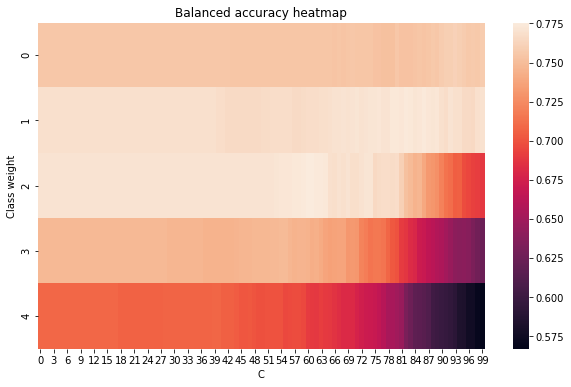

In [68]:
plt.rcParams["figure.figsize"] = (10,6)
sns.heatmap(b_a.T)

plt.title("Balanced accuracy heatmap")
plt.xlabel("C")
plt.ylabel("Class weight")


Text(69.0, 0.5, 'Class weight')

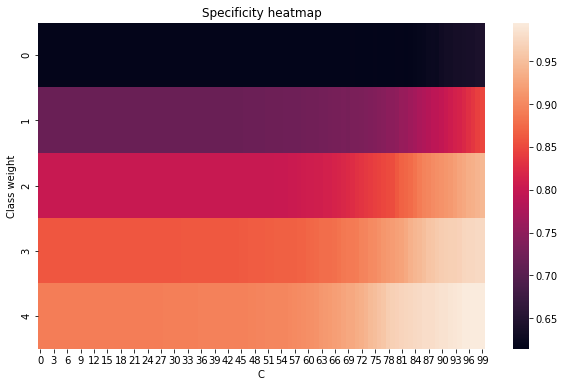

In [70]:
plt.rcParams["figure.figsize"] = (10,6)
sns.heatmap(spe_t.T)

plt.title("Specificity heatmap")
plt.xlabel("C")
plt.ylabel("Class weight")


Text(69.0, 0.5, 'Class weight')

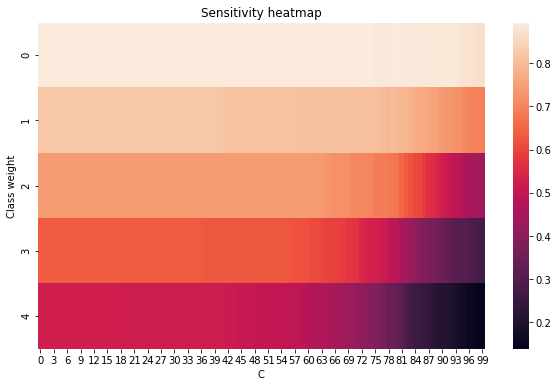

In [71]:
plt.rcParams["figure.figsize"] = (10,6)
sns.heatmap(sen_t.T)

plt.title("Sensitivity heatmap")
plt.xlabel("C")
plt.ylabel("Class weight")


# CM Max sensitivity

In [74]:
args = np.argwhere(sen_t==np.max(sen_t))

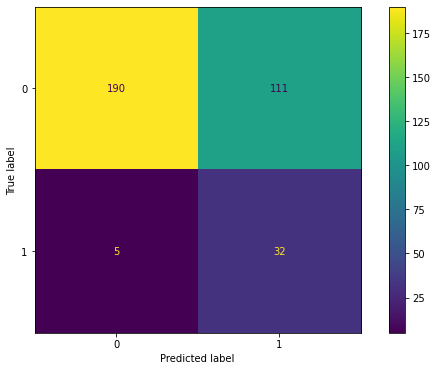

In [78]:
args = np.argwhere(sen_t==np.max(sen_t))

for idx, (train_ids,test_ids) in enumerate(inner_cv.split(X_sc)):
    x_train_l, x_test_l = X_sc[train_ids],X_sc[test_ids]
    y_train_l, y_test_l = Y_dead[train_ids],Y_dead[test_ids]
    
    mdl =LogisticRegression(solver="liblinear", max_iter=10000, C=reg_param[args[0][0]], class_weight=c_w[args[0][1]])
    mdl.fit(x_train_l, y_train_l)
    plot_confusion_matrix(mdl, x_test_l, y_test_l)  

    break;

# CM max specificity